In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
import seaborn as sns
import numpy as np
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
data = pd.read_pickle("../DATA_COLLECTOR/AGGREGATION_PRODUCTION/aggreg_PRODUCTION_data.pkl")
data.Date = pd.to_datetime(data['Date'],format='%Y%m%d')
data = data.sort_values(by='Date')
data = data[data.Date > '2012-12-31']
data = data.set_index('Date')

display(data.tail())
print(len(data))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation
Date,,,,,,,,,,,,,,
2020-02-03,3321,3.075,2910,0,646,13:40,Fine,6,29,NaN,NaN,NaN,NaN,4048
2020-02-04,1611,1.492,1275,0,678,14:30,Mostly Cloudy,8,16,NaN,NaN,NaN,NaN,4084
2020-02-05,4140,3.833,2816,0,737,12:40,Fine,0,16,NaN,NaN,NaN,NaN,4121
2020-02-06,4241,3.927,3585,0,740,13:00,Fine,-2,20,NaN,NaN,NaN,NaN,4157
2020-02-07,2654,2.457,2337,0,740,13:00,Fine,0,21,NaN,NaN,NaN,NaN,4194


2541


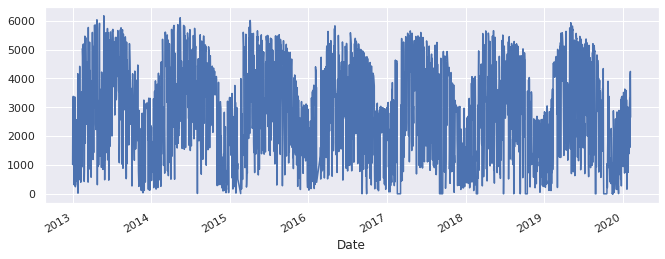

In [3]:
data.Energy_Generated = pd.to_numeric(data.Energy_Generated)
data.Energy_Generated.plot()

In [4]:
data['month'] = data.index.month
data['year'] = data.index.year
data['Weekday_Name'] = data.index.day_name # data.index.weekday_name not available in pandas 1.0
#data = data.reset_index()
#data

**Choose a date threshold to separate training and testing data**

In [5]:
thresh_date = '2018-12-31' #'2019-02-07', '2019-08-31'
train_data = data[data.index < thresh_date]
test_data = data[data.index > thresh_date]
display(train_data.head(2))
display(test_data.head(2))

print("Train size %d, test size %d" % (len(train_data), len(test_data)))

,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation,month,year,Weekday_Name
Date,,,,,,,,,,,,,,,,,
2013-01-01,1013,0.938,998,0,807,13:10,Showers,8,13,NaN,NaN,NaN,NaN,3458,1,2013,<bound method PandasDelegate._add_delegate_acc...
2013-01-02,2878,2.665,2840,0,837,13:00,Mostly Cloudy,7,13,NaN,NaN,NaN,NaN,3472,1,2013,<bound method PandasDelegate._add_delegate_acc...


,Energy_Generated,Efficiency,Energy_Exported,Energy_Used,Peak_Power,Peak_Time,Condition,Min_Temperature,Max_Temperature,Peak_Energy_Import,Off-Peak_Energy_Import,Shoulder_Energy_Import,High-Shoulder_Energy_Import,Insolation,month,year,Weekday_Name
Date,,,,,,,,,,,,,,,,,
2019-01-01,2022,1.872,1637,0,744,13:05,Fine,-2,9,NaN,NaN,NaN,NaN,3243,1,2019,<bound method PandasDelegate._add_delegate_acc...
2019-01-02,277,0.256,88,0,116,14:40,Showers,2,4,NaN,NaN,NaN,NaN,3255,1,2019,<bound method PandasDelegate._add_delegate_acc...


Train size 2139, test size 401


**Resample data (month aggregation)**

Date
2013-01-31    1567.161290
2013-02-28    2438.821429
2013-03-31    3316.366667
2013-04-30    3445.241379
2013-05-31    2819.000000
                 ...     
2018-08-31    3514.766667
2018-09-30    3503.866667
2018-10-31    1807.322581
2018-11-30    1729.866667
2018-12-31    1536.466667
Freq: M, Name: Energy_Generated, Length: 72, dtype: float64

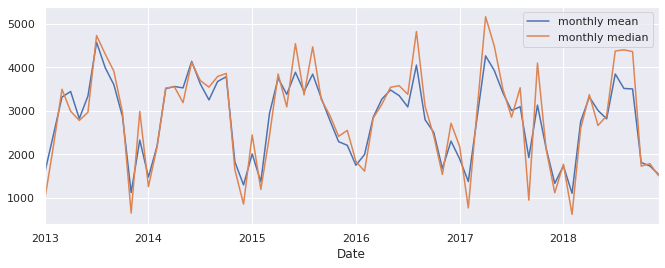

In [6]:
#monthly_data_mean = data.groupby(['year','month']).mean().reset_index()
all_monthly_data_mean = data.Energy_Generated.resample('M').mean()
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()
monthly_data_median = train_data.Energy_Generated.resample('M').median()
monthly_data_sum = train_data.Energy_Generated.resample('M').sum()
display(monthly_data_mean)

monthly_data_mean.plot(label='monthly mean')
monthly_data_median.plot(label='monthly median')
plt.legend()

In [7]:
M_train_size = len(monthly_data_mean)
print(M_train_size)

72


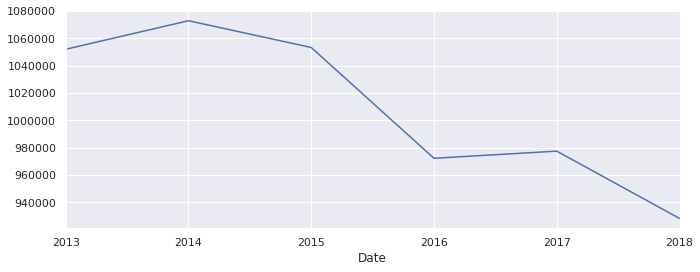

In [8]:
annual_data_sum = train_data.Energy_Generated.resample('A').sum()
annual_data_sum.plot()

**Rolling window**

In [9]:
energy_28d = train_data.Energy_Generated.rolling(28, center=True).mean()
energy_365d = train_data.Energy_Generated.rolling(window=365, center=True, min_periods=360).mean()

**Stationarity study**

<Figure size 792x288 with 0 Axes>

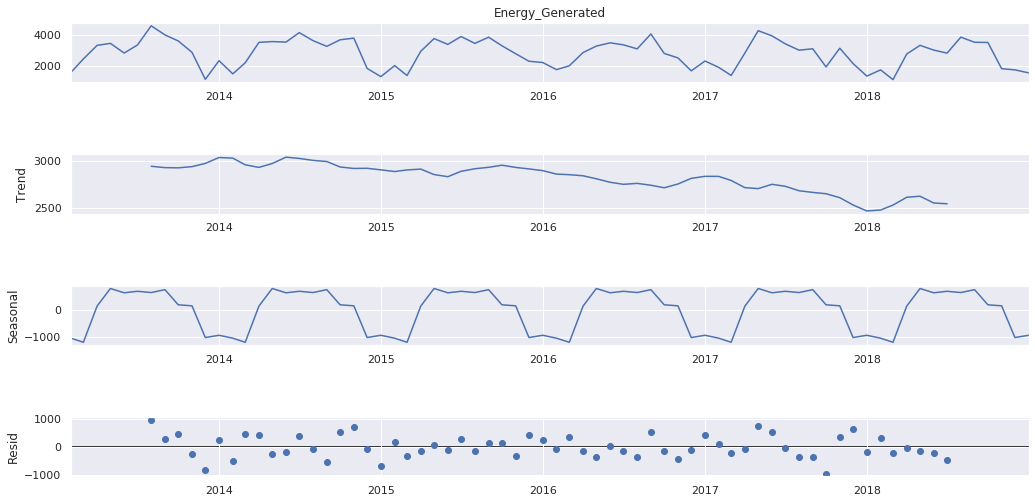

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

energy_28d = energy_28d.dropna()
decomposition = seasonal_decompose(monthly_data_mean, period=12) 

fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

In [11]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):  
    #Determing rolling statistics
    rolmean = timeseries.rolling(12, center=True).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    fig  = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std  = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


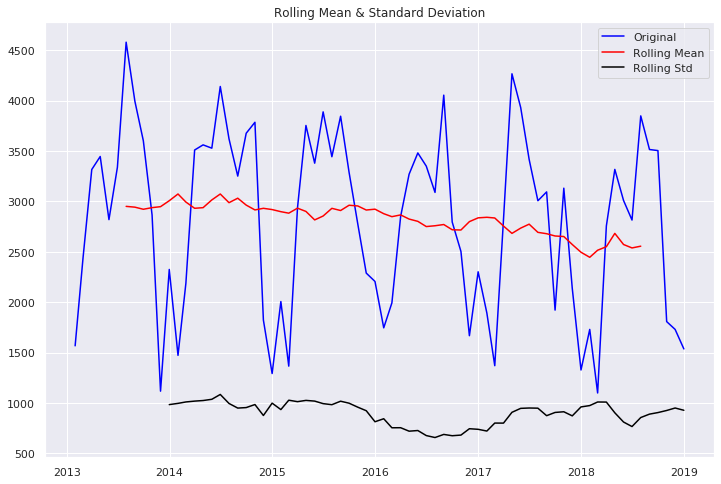

Results of Dickey-Fuller Test:
Test Statistic                 -0.613552
p-value                         0.867890
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [12]:
test_stationarity(monthly_data_mean)

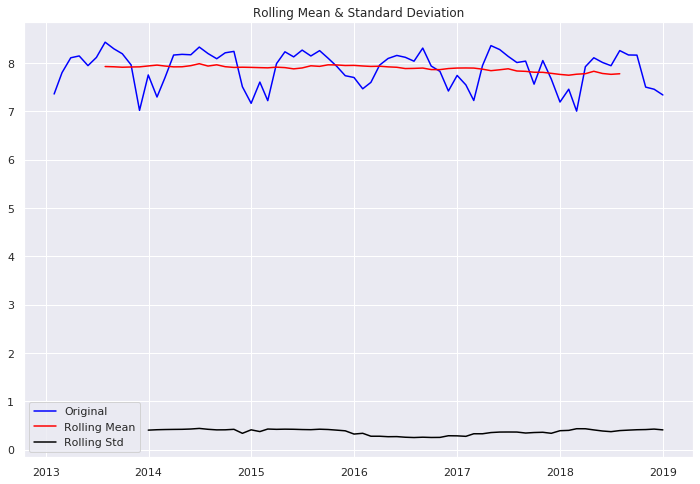

Results of Dickey-Fuller Test:
Test Statistic                 -0.253173
p-value                         0.931880
#Lags Used                     12.000000
Number of Observations Used    59.000000
Critical Value (1%)            -3.546395
Critical Value (5%)            -2.911939
Critical Value (10%)           -2.593652
dtype: float64


In [13]:
monthly_data_mean_log = monthly_data_mean.apply(lambda x: np.log(x))  
test_stationarity(monthly_data_mean_log)

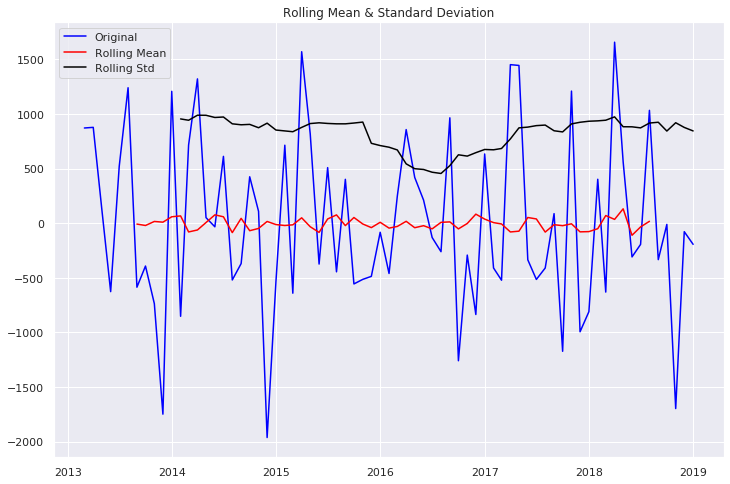

Results of Dickey-Fuller Test:
Test Statistic                -5.785933e+00
p-value                        4.999591e-07
#Lags Used                     1.200000e+01
Number of Observations Used    5.800000e+01
Critical Value (1%)           -3.548494e+00
Critical Value (5%)           -2.912837e+00
Critical Value (10%)          -2.594129e+00
dtype: float64


In [14]:
monthly_data_mean_first_diff = monthly_data_mean - monthly_data_mean.shift(1)  
test_stationarity(monthly_data_mean_first_diff.dropna(inplace=False))

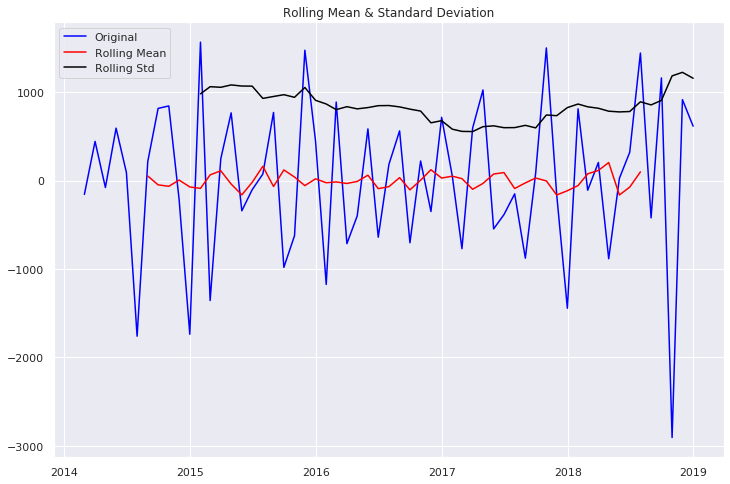

Results of Dickey-Fuller Test:
Test Statistic                -6.572223e+00
p-value                        7.883918e-09
#Lags Used                     4.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


In [15]:
monthly_data_mean_seasonal_first_difference = monthly_data_mean_first_diff - monthly_data_mean_first_diff.shift(12)  
test_stationarity(monthly_data_mean_seasonal_first_difference.dropna(inplace=False))

**Autocorrelation study**

/home/cynthia/.local/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


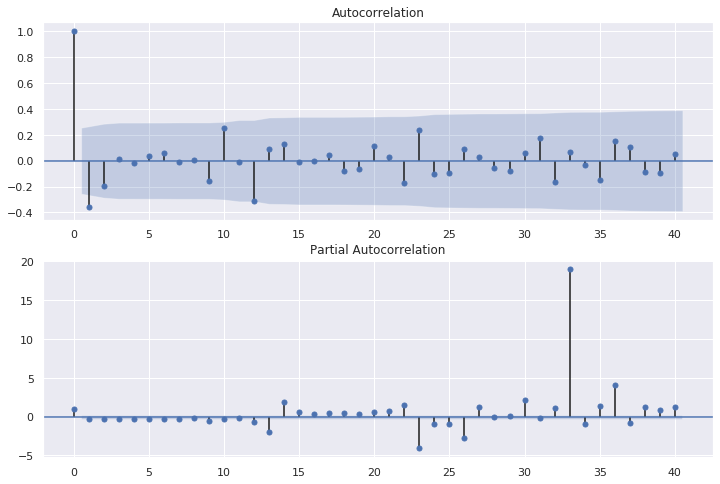

In [16]:
import statsmodels.api as sm 

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(monthly_data_mean_seasonal_first_difference.iloc[13:], lags=40, ax=ax2)

Text(0.5, 1.0, 'Trends in Generated Energy')

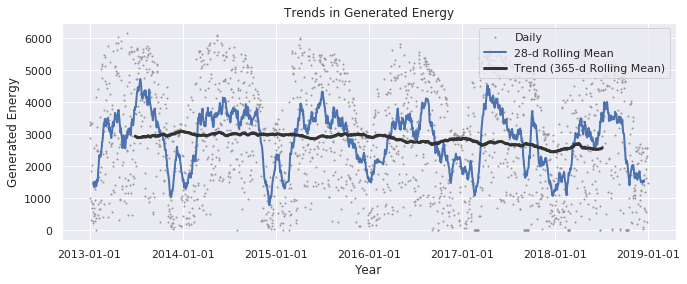

In [17]:
import matplotlib.dates as mdates

# Plot daily, 28-day rolling mean, and 365-day rolling mean time series
fig, ax = plt.subplots()
ax.plot(train_data.Energy_Generated, marker='.', markersize=2, color='0.6',
linestyle='None', label='Daily')
ax.plot(energy_28d, linewidth=2, label='28-d Rolling Mean')
ax.plot(energy_365d, color='0.2', linewidth=3,
label='Trend (365-d Rolling Mean)')
# Set x-ticks to yearly interval and add legend and labels
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Generated Energy')
ax.set_title('Trends in Generated Energy')

[1441.25       1494.53571429 1507.46428571 ... 1510.78571429 1553.71428571
 1572.17857143]


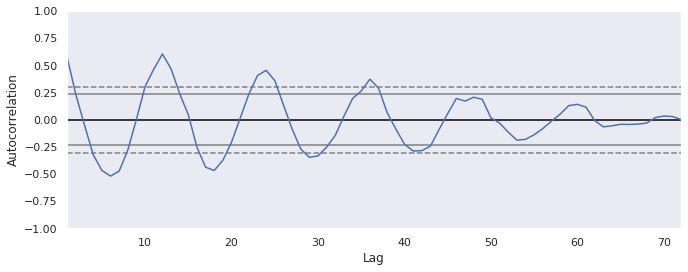

In [18]:
from pandas.plotting import autocorrelation_plot
energy_28d = energy_28d.dropna()
autocorrelation_plot(monthly_data_mean)
print(energy_28d.values)

##Boxplot
boxplot = False
if boxplot:
    years = range(2013,2020,1)
    fig, axes = plt.subplots(len(years), 1, figsize=(11, 10), sharex=True)
    for name, ax in zip(years, axes):
        new_data = pd.DataFrame()
        new_data['month'] = data[(data.year == name)].month.values
        new_data['Weekday_Name'] = data[(data.year == name)]['Weekday_Name'].values
        new_data['generated_energy'] = data[(data.year == name)].Energy_Generated.values
        ax = sns.boxplot(data=new_data, x='month',y="generated_energy",ax=ax)
        ax.set_ylabel('energy')
        ax.set_title(str(name))
        if ax != axes[-1]:
            ax.set_xlabel('')

In [19]:
monthly_data_mean.count()

72

**SARIMA forecasting**

In [20]:
mod = sm.tsa.statespace.SARIMAX(monthly_data_mean, trend='n', order=(0,1,1), seasonal_order=(1,1,1,12))
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                   Energy_Generated   No. Observations:                   72
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -455.335
Date:                            Thu, 13 Feb 2020   AIC                            918.669
Time:                                    11:08:35   BIC                            926.980
Sample:                                01-31-2013   HQIC                           921.913
                                     - 12-31-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9995     13.739     -0.073      0.942     -27.928      25.929
ar.S.L12      -0.1090      0.281   

count      72.000000
mean      -59.001910
std       671.045578
min     -1947.452035
25%      -535.865381
50%       -23.456648
75%       394.675901
max      1567.161290
dtype: float64


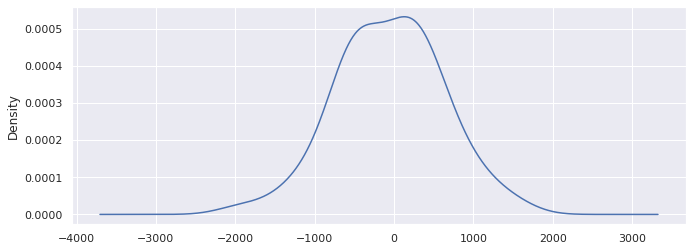

In [21]:
residuals = results.resid
#residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

In [22]:
test_monthly_data_mean = test_data.Energy_Generated.resample('M').mean()
M_test_size = len(test_monthly_data_mean)
print(M_test_size)

14


2019-01-31    1532.287986
2019-02-28    1392.501994
2019-03-31    2704.384883
2019-04-30    3404.267788
2019-05-31    3191.417462
2019-06-30    3178.953670
2019-07-31    3228.176418
2019-08-31    3321.539132
2019-09-30    2717.219205
2019-10-31    2490.879598
2019-11-30    1622.781848
2019-12-31    1501.063339
2020-01-31    1463.655366
2020-02-29    1270.380669
2020-03-31    2619.909990
Freq: M, dtype: float64


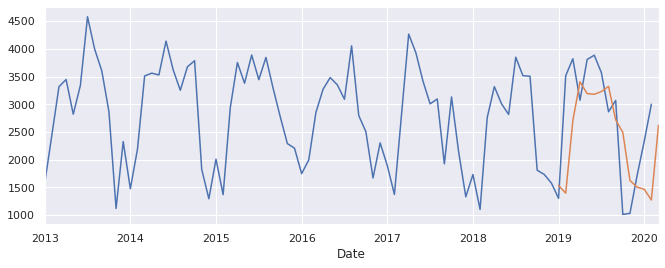

In [23]:
end   = M_test_size + M_train_size
start = M_train_size
forecast_values = results.predict(start=start, end=end, dynamic=True)
all_monthly_data_mean.plot()
forecast_values.plot()

print(forecast_values)

In [24]:
from sklearn.metrics import mean_squared_error

print(pd.concat([forecast_values, test_monthly_data_mean], axis=1, sort=False))
rmse = mean_squared_error(test_monthly_data_mean.values, forecast_values.values[:M_test_size],squared=False) #**1/2 was evaluated as *0.5 and not pow(0.5)
print("RMSE = %d" % rmse) 

                      0  Energy_Generated
2019-01-31  1532.287986       1299.166667
2019-02-28  1392.501994       3514.285714
2019-03-31  2704.384883       3820.903226
2019-04-30  3404.267788       3070.866667
2019-05-31  3191.417462       3806.967742
2019-06-30  3178.953670       3884.896552
2019-07-31  3228.176418       3567.774194
2019-08-31  3321.539132       2862.903226
2019-09-30  2717.219205       3067.266667
2019-10-31  2490.879598       1009.129032
2019-11-30  1622.781848       1028.166667
2019-12-31  1501.063339       1710.000000
2020-01-31  1463.655366       2329.193548
2020-02-29  1270.380669       2999.285714
2020-03-31  2619.909990               NaN
RMSE = 984


**Holt Winter’s Exponential Smoothing (HWES) forecast**

/home/cynthia/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


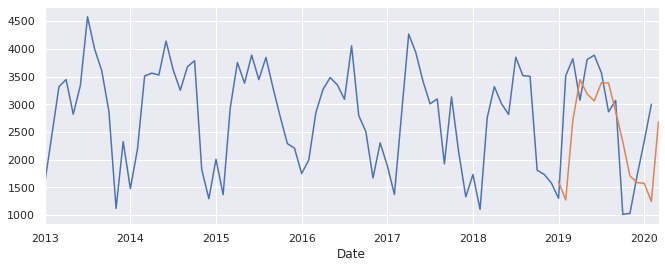

In [34]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# fit model
model = ExponentialSmoothing(monthly_data_mean, seasonal='mul', seasonal_periods=12)
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(start=start, end=end)
all_monthly_data_mean.plot()
yhat.plot()

In [35]:
from sklearn.metrics import mean_squared_error

print(pd.concat([yhat, test_monthly_data_mean], axis=1, sort=False))
rmse = mean_squared_error(test_monthly_data_mean.values, yhat.values[:M_test_size],squared=False)
print("RMSE = %d" % rmse) 

                      0  Energy_Generated
2019-01-31  1599.534495       1299.166667
2019-02-28  1271.733244       3514.285714
2019-03-31  2712.395062       3820.903226
2019-04-30  3443.721970       3070.866667
2019-05-31  3185.373693       3806.967742
2019-06-30  3058.490111       3884.896552
2019-07-31  3388.489844       3567.774194
2019-08-31  3382.210646       2862.903226
2019-09-30  2867.498514       3067.266667
2019-10-31  2320.623525       1009.129032
2019-11-30  1703.435402       1028.166667
2019-12-31  1584.285610       1710.000000
2020-01-31  1570.666594       2329.193548
2020-02-29  1244.384706       2999.285714
2020-03-31  2686.485921               NaN
RMSE = 990


**Facebook Prophet model forecast**

In [36]:
from fbprophet import Prophet

In [37]:
monthly_data_mean = monthly_data_mean.reset_index()
monthly_data_mean = monthly_data_mean.rename(columns={'Date': 'ds','Energy_Generated': 'y'})

In [38]:
#Prophet
model=Prophet(interval_width=0.95, yearly_seasonality=True, daily_seasonality=True)

In [39]:
model.fit(monthly_data_mean)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
/home/cynthia/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



In [46]:
#print(monthly_data_mean)
future_dates = model.make_future_dataframe(periods=M_test_size, freq='MS')
forecast = model.predict(future_dates)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

/home/cynthia/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



,ds,yhat,yhat_lower,yhat_upper
81,2019-10-01,2405.331240,1649.792460,3211.280850
82,2019-11-01,2649.902867,1942.330235,3368.567258
83,2019-12-01,1145.285605,409.223342,1920.895211
84,2020-01-01,1806.080689,1010.706831,2543.145020
85,2020-02-01,1135.880135,424.790052,1882.965389


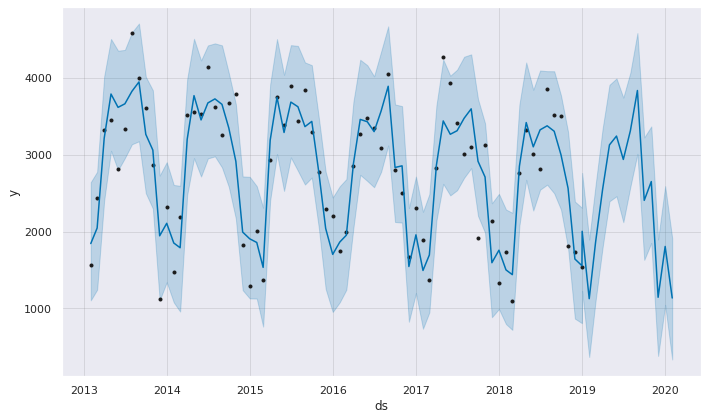

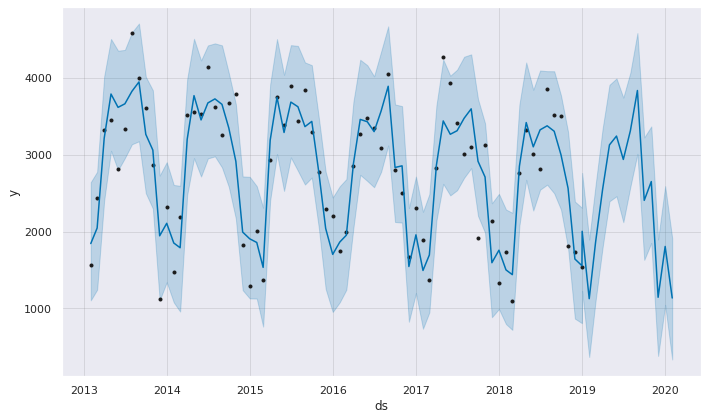

In [43]:
model.plot(forecast,uncertainty=True)

/home/cynthia/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.

/home/cynthia/.local/lib/python3.6/site-packages/fbprophet/forecaster.py:400: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.



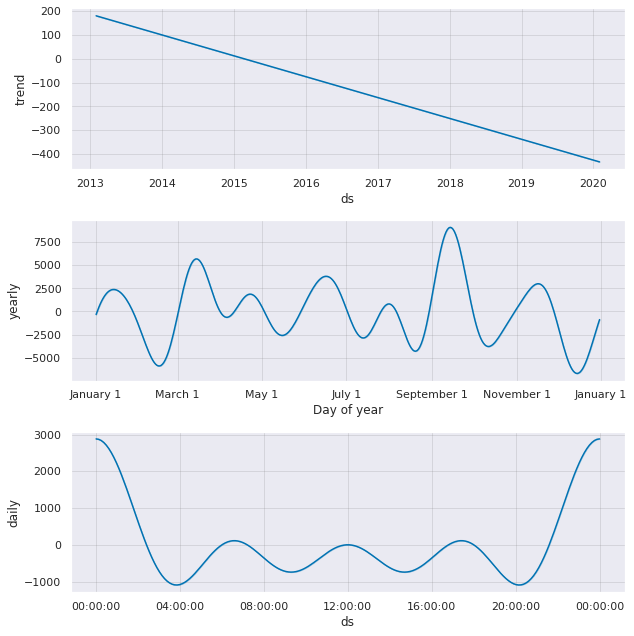

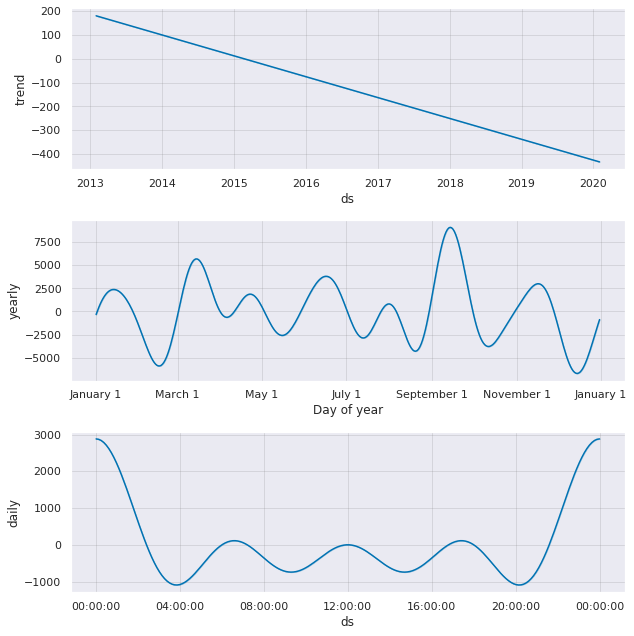

In [51]:
model.plot_components(forecast)

In [52]:
print(pd.concat([yhat, test_monthly_data_mean], axis=1, sort=False))
rmse = mean_squared_error(test_monthly_data_mean.values, forecast[['yhat']].tail(M_test_size).values,squared=False)
print("RMSE = %d" % rmse) 

                      0  Energy_Generated
2019-01-31  1599.534495       1299.166667
2019-02-28  1271.733244       3514.285714
2019-03-31  2712.395062       3820.903226
2019-04-30  3443.721970       3070.866667
2019-05-31  3185.373693       3806.967742
2019-06-30  3058.490111       3884.896552
2019-07-31  3388.489844       3567.774194
2019-08-31  3382.210646       2862.903226
2019-09-30  2867.498514       3067.266667
2019-10-31  2320.623525       1009.129032
2019-11-30  1703.435402       1028.166667
2019-12-31  1584.285610       1710.000000
2020-01-31  1570.666594       2329.193548
2020-02-29  1244.384706       2999.285714
2020-03-31  2686.485921               NaN
RMSE = 1225


### Bayesian dynamic linear model

Initializing models...
Initialization finished.
Starting forward filtering...
Forward filtering completed.
Starting backward smoothing...
Backward smoothing completed.


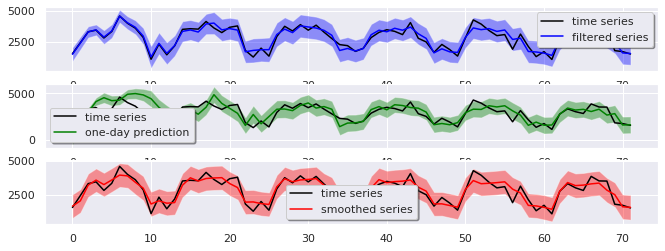

In [53]:
#Bayesian
monthly_data_mean = train_data.Energy_Generated.resample('M').mean()

from pydlm import dlm, trend, seasonality
# A linear trend
linear_trend = trend(degree=1, discount=0.95, name='linear_trend', w=10)
# A seasonality
seasonal12 = seasonality(period=12, discount=0.99, name='seasonal12', w=10)
# Build a simple dlm
simple_dlm = dlm(monthly_data_mean) + linear_trend + seasonal12
# Fit the model
simple_dlm.fit()
# Plot the fitted results
simple_dlm.turnOff('data points')
simple_dlm.plot()

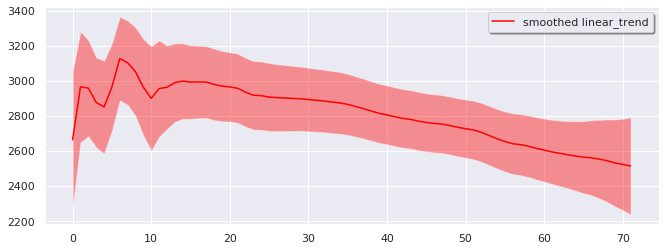

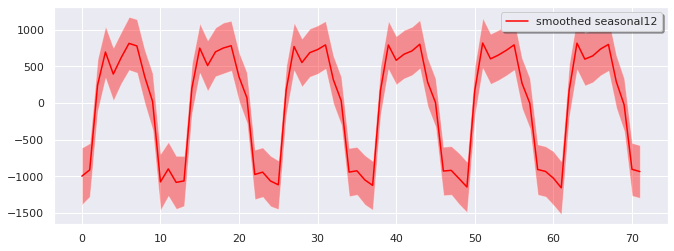

In [54]:
simple_dlm.turnOff('predict plot')
simple_dlm.turnOff('filtered plot')
simple_dlm.plot('linear_trend')
simple_dlm.plot('seasonal12')

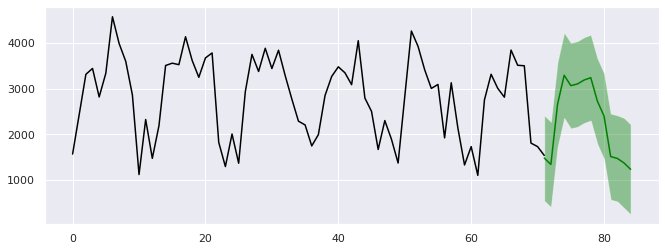

In [63]:
simple_dlm.plotPredictN(date=71, N=M_test_size)

In [60]:
forecast_values = simple_dlm.predictN(date=71, N=M_test_size)[0][:M_test_size]
print(forecast_values)

0     1479.351981
1     1338.499528
2     2656.248270
3     3295.771142
4     3068.467506
5     3104.125593
6     3190.406462
7     3243.112227
8     2727.486372
9     2400.702570
10    1511.473875
11    1471.643638
12    1372.709570
13    1231.857117
Name: forecast, dtype: float64


In [64]:
rmse = mean_squared_error(test_monthly_data_mean.values, forecast_values,squared=False)
print("RMSE = %d" % rmse) 

RMSE = 999
